In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install opencv-python

In [3]:
import cv2
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

In [4]:
import glob
import pandas as pd

seed = 73

arr = []
path = "/content/drive/MyDrive/Colab Notebooks/mask image detection/Face Mask Dataset/"

for strat in os.listdir(path):
    for label in os.listdir(path+"/"+strat):
        for image in glob.glob(path+strat+"/"+label+"/"+"*.png"):
            arr.append({"path": image, "label": label, "strat": strat})
 
 
frame = pd.DataFrame(arr).sample(frac=1, random_state=seed)
print('> WithoutMask:', frame.value_counts("label")[0])
print('> WithMask:', frame.value_counts("label")[1])

frame

> WithoutMask: 5909
> WithMask: 5883


,path,label,strat
11179,/content/drive/MyDrive/Colab Notebooks/mask im...,WithMask,Validation
1100,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
4758,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
10843,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Test
3223,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
...,...,...,...
4419,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
8586,/content/drive/MyDrive/Colab Notebooks/mask im...,WithMask,Train
4014,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
8338,/content/drive/MyDrive/Colab Notebooks/mask im...,WithMask,Train


### Data Preprocessing

In [5]:
IMG_SIZE = 128
input_shape=(IMG_SIZE, IMG_SIZE, 3)

In [6]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip=True,
                             brightness_range=[1.1, 1.3],
                             rotation_range=30,
                             zoom_range=0.15
                             )

In [7]:
def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          directory="/content/drive/MyDrive/Colab Notebooks", 
                          x_col="path",
                          y_col="label",
                          batch_size=64,
                          seed=seed,
                          shuffle=False,
                          class_mode="binary",
                          target_size=(IMG_SIZE,IMG_SIZE))
    return generator

In [8]:
train_df = frame[frame["strat"] == "Train"].sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

Found 10000 validated image filenames belonging to 2 classes.


In [9]:
valid_df = frame[frame["strat"] == "Validation"].sample(frac=1, random_state=seed)
valid_generator = get_generator(valid_df)

Found 800 validated image filenames belonging to 2 classes.


In [10]:
test_df = frame[frame["strat"] == "Test"].sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

Found 992 validated image filenames belonging to 2 classes.


In [11]:
train_generator

In [12]:
train_df

,path,label,strat
725,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
1202,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
1564,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
1665,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
3669,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
...,...,...,...
6328,/content/drive/MyDrive/Colab Notebooks/mask im...,WithMask,Train
4412,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train
7461,/content/drive/MyDrive/Colab Notebooks/mask im...,WithMask,Train
2890,/content/drive/MyDrive/Colab Notebooks/mask im...,WithoutMask,Train


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 725 to 4866
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
 1   label   10000 non-null  object
 2   strat   10000 non-null  object
dtypes: object(3)
memory usage: 312.5+ KB


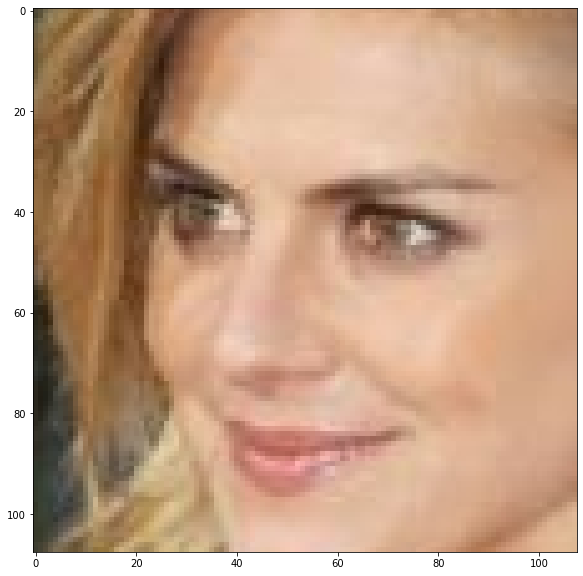

/content/drive/MyDrive/Colab Notebooks/mask image detection/Face Mask Dataset/Train/WithoutMask/5038.png 



In [15]:
inp_img = cv2.imread(train_df['path'][0])
plt.figure(figsize=(15,10))
inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
plt.imshow(inp_img)
plt.show()
print(train_df['path'][0], '\n')

### Xception Net

In [16]:
import random
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [17]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential

final_activation = 'sigmoid'
entropy = 'binary_crossentropy'

In [18]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    
    headModel = Dense(units=256)(headModel)
    headModel = BatchNormalization()(headModel)    
    headModel = Activation('relu')(headModel)
    headModel = Dropout(0.6, seed=42)(headModel)    
    
    headModel = Dense(1, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    
    return model

In [29]:
import tensorflow as tf

def Xception_Model():
  img_input = Input(shape=input_shape)
  model =  tf.keras.applications.xception.Xception(
          include_top=True, input_tensor=None, weights = None,
          input_shape=None, pooling='max', classes=1,
          classifier_activation='sigmoid')
  #model = FCLayers(model)
  model.summary()
  return model
model = Xception_Model()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1)

model_checkpoints = ModelCheckpoint("XceptionModel.h5", 
                                    save_best_only=True, verbose = 1)


callbacks = [model_checkpoints, early_stopping]

In [23]:
pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-cp37-none-any.whl size=9018 sha256=a61d82c88ab161ed99c3c3e7a42b834a6882f5af6396b1fd1e122b921e1bca91
  Stored in directory: /root/.cache/pip/wheels/02/1e/17/465c89b2c5ce7670a3fc6c20c40e1dad994109d015d57a024e
Successfully built keras-rectified-adam


In [31]:
from keras_radam import RAdam
optimizer = RAdam()
model.compile(optimizer=optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])


history = model.fit(train_generator,validation_data  = valid_generator, epochs = 50, 
                              steps_per_epoch=(len(train_generator.labels) / 80) ,
                              validation_steps=(len(valid_generator.labels) / 80),
                    callbacks = callbacks)

Epoch 1/50
125/125 [==============================] - 93s 566ms/step - loss: 0.1856 - accuracy: 0.9178 - val_loss: 0.6957 - val_accuracy: 0.4953

Epoch 00001: val_loss improved from inf to 0.69571, saving model to XceptionModel.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
125/125 [==============================] - 70s 560ms/step - loss: 0.0601 - accuracy: 0.9771 - val_loss: 0.7018 - val_accuracy: 0.4953

Epoch 00002: val_loss did not improve from 0.69571
Epoch 3/50
125/125 [==============================] - 70s 558ms/step - loss: 0.0423 - accuracy: 0.9847 - val_loss: 0.7051 - val_accuracy: 0.4953

Epoch 00003: val_loss did not improve from 0.69571
Epoch 4/50
125/125 [==============================] - 70s 558ms/step - loss: 0.0392 - accuracy: 0.9858 - val_loss: 0.6313 - val_accuracy: 0.7000

Epoch 00004: val_loss improved from 0.69571 to 0.63129, saving model to XceptionModel.h5
Epoch 5/50
125/125 [==============================] - 70s 560ms/step - loss: 0.0271 - accuracy: 0.9898 - val_loss: 0.1480 - val_accuracy: 0.9797

Epoch 00005: val_loss improved from 0.63129 to 0.14801, saving model to XceptionModel.h5
Epoch 6/50
125/125 [==============================] - 70s 558ms/step - loss: 0.0342 - accuracy: 0.9883 - val_loss: 0.0451 - val_accuracy

In [33]:
from tensorflow.keras.models import load_model
model = load_model("XceptionModel.h5", custom_objects={'MyObtimizer':optimizer})

ValueError: ignored

### Evaluation

In [34]:
model.evaluate(test_generator, verbose=1)

16/16 [==============================] - 287s 19s/step - loss: 0.0212 - accuracy: 0.9899


[0.02115217037498951, 0.9899193644523621]

In [35]:
predictions = model.predict(test_generator, verbose = 1).round()

16/16 [==============================] - 7s 365ms/step


In [36]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
target_names = ['Has Mask','No Mask']

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_results():
    print(classification_report(test_generator.labels, predictions, target_names=target_names))
    plt.figure(figsize = (8,5))
    sns.heatmap(confusion_matrix(test_generator.labels, predictions), annot = True, 
                fmt="d",cmap = "Purples")
    plt.show()
    
    roc_acc = roc_auc_score(test_generator.labels, predictions)
    print('> ROC Accuracy: {}'.format(roc_acc.round(4)))

              precision    recall  f1-score   support

    Has Mask       1.00      0.98      0.99       483
     No Mask       0.98      1.00      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



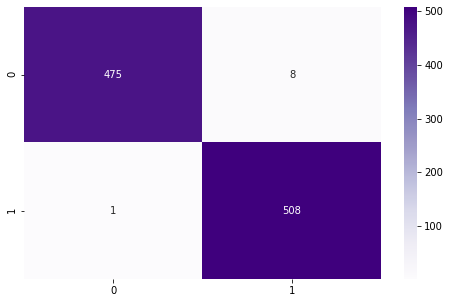

> ROC Accuracy: 0.9907


In [38]:
print_results()

In [39]:
import cv2
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/package_collection/haarcascades/haarcascade_frontalface_default.xml')

def getFaces(img):
    gray_img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(gray_img, scaleFactor=1.1, 
                                        minNeighbors=8)
    return faces

In [40]:
import PIL

def newSize(width, height):
    if width < 600:
        return newSize(width * 1.12 , height * 1.12)
    
    if width >= 1200:
        return newSize(width / 1.12 , height / 1.12)
        
    return int(width), int(height)
        
def AdjustSize(f):
    img = PIL.Image.open(f)
    width, height = img.size
    new_width, new_height = newSize(width, height)
    
    return (new_width, new_height)  

In [57]:
import numpy as np


def Draw(img, face):
    (x,y,w,h) = face
    mask_label = {0:'Has Mask!',1:'No Mask'}
    label_color = {0: (0,255,0), 1: (255,0,0)}
    
    crop = img[y:y+h,x:x+w]
    
    crop = cv2.resize(crop,(299, 299))
    crop = np.reshape(crop,[1,299,299,3]) / 255.0
    
    mask_result = model.predict(crop)
            
    pred_label = round(mask_result[0][0])
            
    cv2.putText(img,mask_label[pred_label],
                (x, y+90), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, label_color[pred_label], 2)
            
    cv2.rectangle(img,(x,y),(x+w,y+h), 
                label_color[pred_label],1)
    
    return img

In [58]:
from io import BytesIO
from skimage import io
from scipy.spatial import distance
import requests

MIN_DISTANCE = 0
    
def MaskDetection(imgUri):    
    response = requests.get(imgUri)
    f = BytesIO(response.content)
    
    img = io.imread(f)
    resize = AdjustSize(f)
    img = cv2.resize(img, resize)
    faces = getFaces(img)
    
    if len(faces)>=1:
        label = [0 for i in range(len(faces))]
        
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
                dist = distance.euclidean(faces[i][:2], 
                                          faces[j][:2])
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1
                
        for i in range(len(faces)):
            Draw(img, faces[i])
                        
        plt.figure(figsize=(16,14))
        plt.imshow(img)
            
    else:
        print("No Face!")

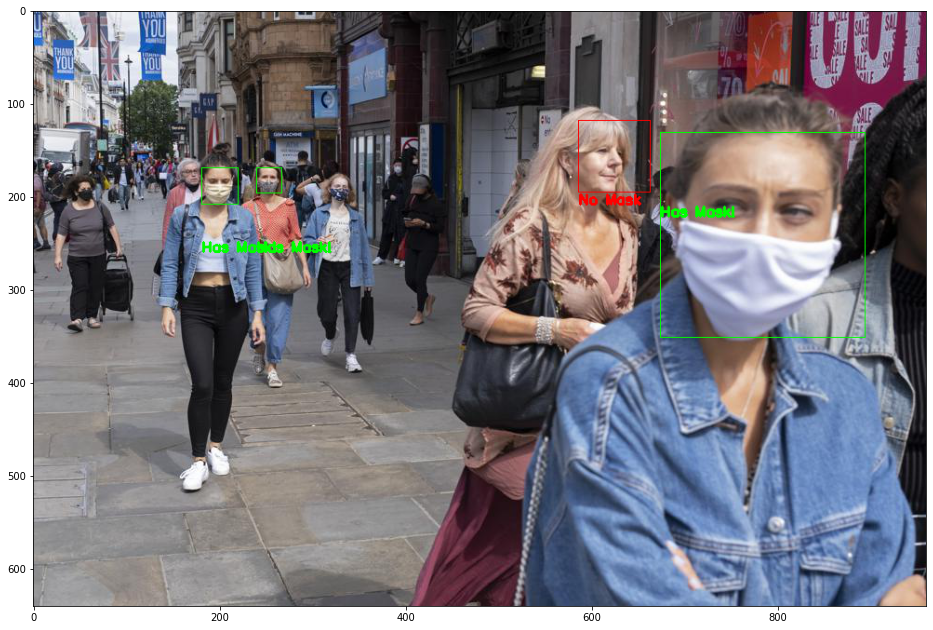

In [59]:
MaskDetection("https://specials-images.forbesimg.com/imageserve/1227664783/960x0.jpg?fit=scale")

In [ ]:
from IPython.display import FileLink
FileLink(r'./XceptionModel.h5')